In [1]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

## MDS-MISIS-DL CAPTCHA Symbols Recognition

### Recognise letters of the English alphabet as CAPTCHAs

https://www.kaggle.com/competitions/mds-misis-dl-captchan

----

### Step 0: Load The Data

In [2]:
#load data
import numpy as np
images = np.load('data/images.npy')
labels = np.load('data/labels.npy')

We have 20000 RGB images of size 48x48, therefore `images` arrays shall have size (20000, 48, 48, 3). 

In [3]:
images.shape

(20000, 48, 48, 3)

In [4]:
image_shape = images[0].shape

`labels` contain answers for train set. 

In English alphabet we have 26 symbols: class with label `0` corresponds to `A` and label `25` corresponds to `Z`

In [5]:
import string 

alphabet_string = string.ascii_uppercase
alphabet_list = list(alphabet_string)
n_classes = len(alphabet_list)
print(n_classes)
print(alphabet_list)

26
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### Step 1: Dataset Summary & Exploration

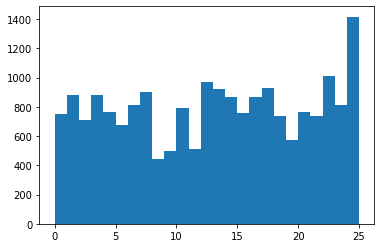

In [6]:
# How many samples of each class there are in dataset

import matplotlib.pyplot as plt

_ = plt.hist(labels, bins=list(range(0, n_classes)))

We might consider removing some samples with label `26` to evenly train our model.

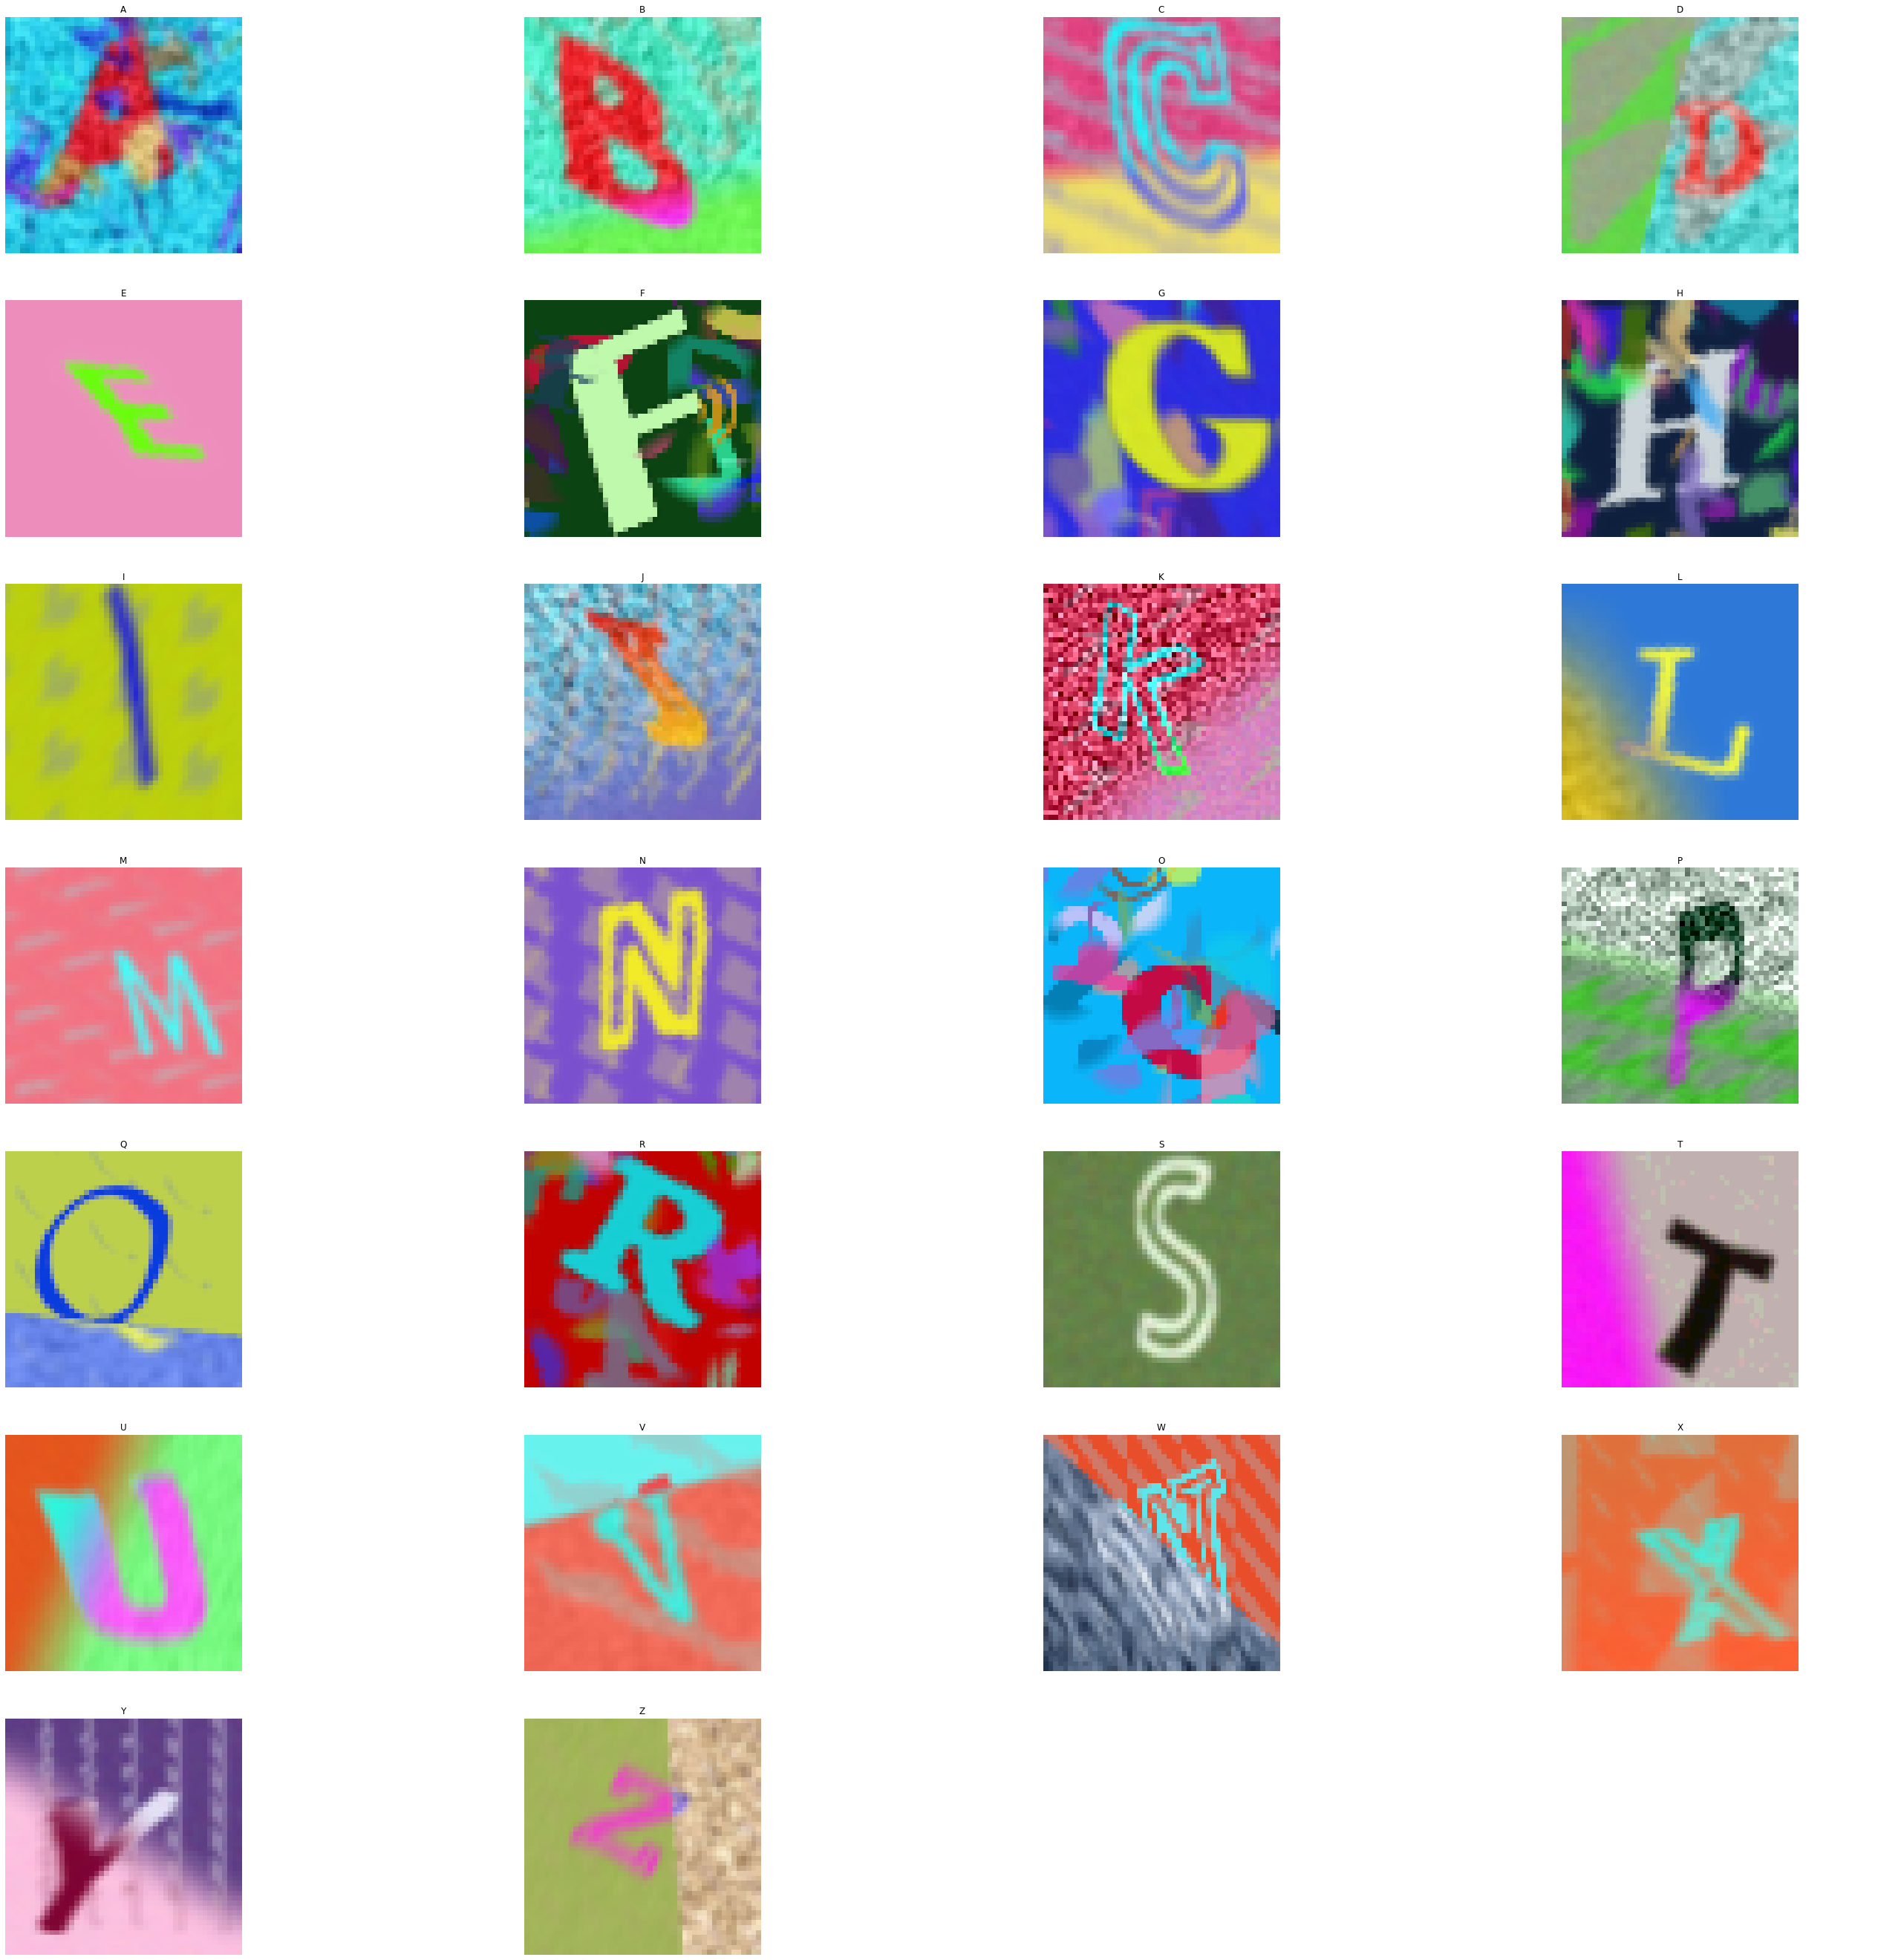

In [7]:
# Now lets visualize some samples with different labels from training set

%matplotlib inline

image_examples = []

fig, axes = plt.subplots(
             ncols=4,
             nrows=7,
             figsize=image_shape[0:2])

axes = axes.ravel()

for i in range(n_classes):
    idx = np.where(labels == i)
    axes[i].imshow(images[idx][0])
    axes[i].set_title(alphabet_list[i])

for ax in axes:    
    ax.axis('off')
   
plt.show()

### Step 3: Prepare PyTorch train dataset

We shall normalize data and convert to grayscale, color is not a letter feature.


In [8]:
import cv2

def normalize(darray_img):    
    img = darray_img.astype(float)
    img = np.divide((img - 128.0), 128.0)
    return img

def rgb2gray(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

In [9]:
normalized_images = np.array([normalize(rgb2gray(img)) for img in images])

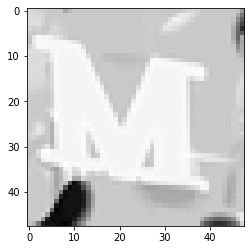

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(normalized_images[33], cmap='Greys')

### Step 4: Design and Test a Model Architecture

In [11]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.nn import LeakyReLU

In [12]:
# Convert to torch format

# numpy image: H x W x C
# torch image: C x H x W
normalized_images = normalized_images.reshape(normalized_images.shape[0], 
                                              1,
                                              image_shape[0],
                                              image_shape[1]) 

train_data_torch = torch.from_numpy(normalized_images)
train_labels_torch = torch.from_numpy(labels)

In [13]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Let's calculate sizes:

Input size of image: 48x48. We have one input channel.

1. **Conv2d(in_channels = 1, out_channels = 4, kernel_size = 3, stride = 1, padding = 1)**
k = 3, s = 1, p = 1, n = 48, out_channels = 4

$$ \frac{n + 2p -f}{s} + 1 = 48 $$
Output layer: 48x48x4

2. **MaxPool2d(kernel_size=2, stride=2)**

$$ \frac{n - f}{s} + 1 = 24 $$
Output layer: 24x24x4

3. **Conv2d(in_channels = 4, out_channels = 4, kernel_size = 3, stride = 1,
            padding = 1)**
            
Output layer: 24x24x4


4. **MaxPool2d(kernel_size=2, stride=2)**

Output layer: 12x12x4

In [14]:
from torch.nn import Dropout

In [15]:
class LeCaptchaNet(Module):   
    def __init__(self):
        super(LeCaptchaNet, self).__init__()
        self.layer1 = Sequential(
            Conv2d(1, 32, kernel_size=5, stride=1, padding=2, device = device), # out: 48x48x32
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2)) # out: 24x24x32
        self.layer2 = Sequential(
            Conv2d(32, 64, kernel_size=5, stride=1, padding=2, device = device), # out: 24x24x64
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2)) # out: 12x12x64
        self.layer3 = Sequential(
            Conv2d(64, 64, kernel_size=5, stride=1, padding=2, device = device), # out: 12x12x64
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2)) # out: 6x6x64
        self.drop_out = Dropout()
        self.fc1 = Linear(6*6*64, 1000) #2304, 1000
        self.relu1 = ReLU()
        self.fc2 = Linear(1000, 26) #n_classes = 26
        self.relu2 = ReLU()

    # Defining the forward pass    
    def forward(self, x):
        out = self.layer1(x.float())
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1) # flatten
        out = self.drop_out(out)
        out = self.relu1(out)
        out = self.fc1(out)
        out = self.relu2(out)
        out = self.fc2(out)
        return out

### Step 5: Predict on test data set


In [16]:
# defining the model
model = LeCaptchaNet()
# defining the optimizer
optimizer = Adam(model.parameters(), lr = 0.001)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()


In [17]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(train_data_torch,
                                                                    train_labels_torch, test_size=0.2, random_state=0)

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset


# Define the batch size and the number of epochs
BATCH_SIZE = 64
N_EPOCHS = 30

# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(train_data, train_labels)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


# Get the dataset size for printing (it is equal to N_SAMPLES)
dataset_size = len(dataloader.dataset)

In [19]:
# Loop over epochs
for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    # Loop over batches in an epoch using DataLoader
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        if torch.cuda.is_available():
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()
        
        # prediction for training set
        y_batch_pred = model(x_batch)
        # computing the training and validation loss
        loss = criterion(y_batch_pred, y_batch)
        
        # clearing the Gradients of the model parameters
        optimizer.zero_grad()     
        # computing the updated weights of all the model parameters
        loss.backward()
        optimizer.step()

        # Every 100 batches, print the loss for this batch
        # as well as the number of examples processed so far 
        if id_batch % 100 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"loss: {loss:>7f}  [{current:>5d}/{dataset_size:>5d}]")

Epoch 1
-------------------------------
loss: 3.261120  [   64/16000]
loss: 3.094544  [ 6464/16000]
loss: 2.382736  [12864/16000]
Epoch 2
-------------------------------
loss: 2.321789  [   64/16000]
loss: 2.082042  [ 6464/16000]
loss: 1.685630  [12864/16000]
Epoch 3
-------------------------------
loss: 1.165313  [   64/16000]
loss: 1.702402  [ 6464/16000]
loss: 1.405310  [12864/16000]
Epoch 4
-------------------------------
loss: 1.499214  [   64/16000]
loss: 1.302425  [ 6464/16000]
loss: 1.174917  [12864/16000]
Epoch 5
-------------------------------
loss: 0.950230  [   64/16000]
loss: 1.252161  [ 6464/16000]
loss: 1.322992  [12864/16000]
Epoch 6
-------------------------------
loss: 1.074608  [   64/16000]
loss: 1.289162  [ 6464/16000]
loss: 1.173789  [12864/16000]
Epoch 7
-------------------------------
loss: 1.100034  [   64/16000]
loss: 1.085866  [ 6464/16000]
loss: 0.903711  [12864/16000]
Epoch 8
-------------------------------
loss: 0.695974  [   64/16000]
loss: 0.787849  [ 64

Y Y


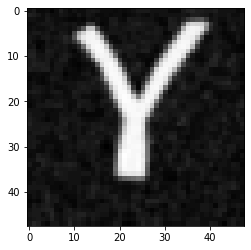

In [20]:
dataset_images, dataset_labels = next(iter(dataloader))
img = dataset_images[0][0]
correct_label = dataset_labels[0]
plt.imshow(img, cmap='Greys')

single_loaded_img = img.to(device)
single_loaded_img = single_loaded_img[None, None]
single_loaded_img = single_loaded_img.type('torch.cuda.FloatTensor')
predicted_result = model(single_loaded_img)
print(alphabet_list[correct_label], alphabet_list[predicted_result.argmax()])

In [29]:
from sklearn.metrics import accuracy_score

# prediction for test part of training set
with torch.no_grad():
    output = model(test_data.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
print(accuracy_score(test_labels, predictions))

0.6135


In [22]:
torch.save(model.state_dict(), './captcha_model.pth')

### Step 6: Predict on final data


In [10]:
model.load_state_dict(torch.load('captcha_model.pth'))

<All keys matched successfully>

In [24]:
import numpy as np
submission_data = np.load('data/images_sub.npy')

In [25]:
submission_data.shape

(50000, 48, 48, 3)

In [26]:
# break to subsets:

n = 5000
submission_resuls = []
for i in range(0, submission_data.shape[0], n):
    submission_data_normalized = np.array([normalize(rgb2gray(img)) for img in submission_data[i:i + n]])
    submission_data_normalized = submission_data_normalized.reshape(submission_data_normalized.shape[0], 
                                                                    1,
                                                                    48,
                                                                    48) 
    submission_data_torch = torch.from_numpy(submission_data_normalized)
    
    with torch.no_grad():
        output = model(submission_data_torch.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    submission_resuls.append(predictions)

In [28]:
import pandas as pd 

# Write data to submission file
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,Id,Category
0,0,13
1,1,20
2,2,12
3,3,7
4,4,8


In [30]:
sample_submission['Category'] = np.concatenate(submission_resuls)
sample_submission.to_csv('captcha_submission.csv', index=False)
sample_submission.head(10)

,Id,Category
0,0,10
1,1,11
2,2,14
3,3,9
4,4,10
5,5,13
6,6,7
7,7,17
8,8,25
9,9,22
